# <center>[⏱ Оптимизация памяти и ускорение вычислений](https://stepik.org/lesson/825508/)</center>

### Оглавление ноутбука

<img src='../images/speed_up.png' align="right" width="550" height="550" />
<br>

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li><a href="#c1">👁 Считывание и сохранение больших датафреймов</a></li>
<li><a href="#c2">🗜 Оптимизация памяти</a></li>
<li><a href="#c3">🥌 Ускорение при помощи `Numpy`</a></li>
<li><a href="#c4">🍢 Векторизация в `pandas`</a></li>
<li><a href="#c5">⚡️ `Numba Jit`</a></li>
<li><a href="#c6">🧵 Multiprocessing</a></li>
<li><a href="#c7">👻 Выводы</a>

</li></ul></font></p>

    

<div class="alert alert-info">
Когда речь заходит о работе с действительно большими данными скорость работы программы и кол-во памяти, которое ей требуется могут стать одним из главных боттлнеков в вашей программе. Особенно если вы ограничены в ресурсах (как например часто бывает на Kaggle) и вам нужно, чтобы ваше решение отработало не только четко, но еще и быстро. В этом уроке мы рассмотрим подходы и методы с помощью которых можно сэкономить память и ускорить ваши вычисления.

## Импортируем библиотеки

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# <center> 👁 Считывание и сохранение больших датафреймов </center>

<p id="c1"></p>   

### Скачаем файлы с гугл-диска

<div class="alert alert-info">
Для начала скачаем большой файл с гугл диска, чтобы на нем замерять скорости в дальнейшем

In [3]:
!pip install gdown -q


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [9]:
# для начала скачаем большой файл с гугл диска, чтобы на нем замерять скорости
!gdown 1Sjb6EYfz23ZuqBGYZfkmhWnBbHQBf6Ke -O '../data/blending/'

Downloading...
From (uriginal): https://drive.google.com/uc?id=1Sjb6EYfz23ZuqBGYZfkmhWnBbHQBf6Ke
From (redirected): https://drive.google.com/uc?id=1Sjb6EYfz23ZuqBGYZfkmhWnBbHQBf6Ke&confirm=t&uuid=54eb8ce9-a3d7-42de-9676-37b286aec0ab
To: /Users/sergak/Documents/Neyro_sets/Competitive_Data_Science/data/blending/text_classification_train.csv
100%|████████████████████████████████████████| 235M/235M [00:20<00:00, 11.5MB/s]


### Работа с `pickle`

<div class="alert alert-info">

`Pickle` это отличная альтернатива привычным нам `.csv` файлам при работе с большими файлами. Мало того, что он считывает и сохраняет все в разы быстрее, так еще и место на диске такой файл занимает меньше. Также при использование `to_pickle()` сохраняются индексы и все типы колонок, так что при его последующем считывании датафрейм будет точно таким же, и его не нужно будет повторно оптимизировать при каждом открытии, как при использовании CSV формата.

In [12]:
%%time

data = pd.read_csv('../data/blending/text_classification_train.csv')

CPU times: user 1.65 s, sys: 160 ms, total: 1.81 s
Wall time: 1.87 s


In [78]:
data.shape

(7500, 2621)

In [79]:
%%time

data.to_csv('../data/blending/text_classification_train.csv')

CPU times: user 8.76 s, sys: 231 ms, total: 8.99 s
Wall time: 9.26 s


In [80]:
%%time

pd.to_pickle(data, '../data/blending/text_classification_train.pickle')

CPU times: user 11.7 ms, sys: 33 ms, total: 44.8 ms
Wall time: 99.1 ms


In [81]:
%%time

data = pd.read_pickle('../data/blending/text_classification_train.pickle')

CPU times: user 12.7 ms, sys: 62.9 ms, total: 75.6 ms
Wall time: 204 ms


In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Columns: 2621 entries, Unnamed: 0.2 to labse_text_feature_767
dtypes: float64(2616), int64(3), object(2)
memory usage: 150.0+ MB


### Считывание по батчам

<div class="alert alert-info">

Если ваш датасет не умещается в память без оптимизации типов или он не нужен вам целиком, то можно считывать по батчам и сразу указывать необхоимые типы, индексы и тд. В параметр `chunksize` - передается число сэмплов, которое будет считываться за 1 итерацию.

In [83]:
import gc

chunksize = 1000
tmp_lst = []
with pd.read_csv('../data/car_train.csv',
                 index_col='car_id',
                 dtype={'model': 'category',
                        'car_type': 'category',
                        'fuel_type': 'category',
                        'target_class': 'category'}, chunksize=chunksize) as reader:
    for chunk in reader:
        tmp_lst.append(chunk)
        
data = pd.concat(tmp_lst)

del tmp_lst
gc.collect()

data.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
car_id,,,,,,,,,
y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug
O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug
d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick
u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel
N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel


***Важно:*** Пока на какой-то объект в памяти есть ссылки, которые явно не удалили или не переназначили - этот объект будет занимать оперативную память, хотя он может больше не использоваться. Поэтому все временные объекты, которые больше не будут использоваться, лучше явно удалять, используя `del` и после этого запускать сборщик мусора gc - `garbage collector`,как в примере выше.
```python
import gc
gc.collect()
```

### Используем генератор

<div class="alert alert-info">
Это особенно актуально, когда мы работаем с картинками - чтобы не хранить их всех в оперативной памяти, они считываются только перед тем как модель хочет посчитать по ним ошибку и скорректировать веса. Однако при работе с большими текстами тоже бывает полезно.

In [84]:
def read_file(filename):
    with open(filename, 'r') as f:
        for line in f:
            yield line.strip()

In [85]:
it = read_file('../data/car_info.csv')
next(it)

'car_type,fuel_type,car_rating,year_to_start,riders,car_id,model,target_class,year_to_work,target_reg'

In [86]:
next(it)

'economy,petrol,4.8,2013,42269,P17494612l,Skoda Rapid,engine_overheat,2019,46.65071890960271'

# <center> 🗜 Оптимизация памяти </center>

<p id="c2"></p>   

<div class="alert alert-info">

Самый эффективный способ оптимизации памяти, если вы не хотите удалять часть данных, это установка правильных типов. Если колонка имеет тип `int`, то не нужно ставить ей тип `float`, а если в ней всего несколько уникальных значений, то не нужно делать ее типом `string`. .Например, если в нашем датасете есть бинарная колонка в которой хранятся только 0 и 1, `pandas` хранит её как максимально возможный тип для целых чисел `int64`, хотя достаточно будет `int8`. При правильной постановке типов размер нового датасета обычно в несколько раз меньше (а то и на порядок), чем без них. Так же можно вынести какую-то колонку как индекс, чтобы не хранить лишний индекс, но это уже косметика.

### Оптимизируем числовые типы

In [87]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [88]:
df_cars = pd.read_csv('../data/car_train.csv')
df_cars.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel


In [89]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   car_id         2337 non-null   object 
 1   model          2337 non-null   object 
 2   car_type       2337 non-null   object 
 3   fuel_type      2337 non-null   object 
 4   car_rating     2337 non-null   float64
 5   year_to_start  2337 non-null   int64  
 6   riders         2337 non-null   int64  
 7   year_to_work   2337 non-null   int64  
 8   target_reg     2337 non-null   float64
 9   target_class   2337 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 182.7+ KB


In [90]:
df_cars = reduce_mem_usage(df_cars)
df_cars.info()

Memory usage of dataframe is 0.18 MB
Memory usage after optimization is: 0.12 MB
Decreased by 35.0%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   car_id         2337 non-null   object 
 1   model          2337 non-null   object 
 2   car_type       2337 non-null   object 
 3   fuel_type      2337 non-null   object 
 4   car_rating     2337 non-null   float16
 5   year_to_start  2337 non-null   int16  
 6   riders         2337 non-null   int32  
 7   year_to_work   2337 non-null   int16  
 8   target_reg     2337 non-null   float16
 9   target_class   2337 non-null   object 
dtypes: float16(2), int16(2), int32(1), object(5)
memory usage: 118.8+ KB


### Оптимизируем категориальные фичи

In [91]:
def convert_columns_to_catg(df, column_list):
    for col in column_list:
        print("converting", col.ljust(30), "size: ", round(df[col].memory_usage(deep=True)*1e-6,2), end="\t")
        df[col] = df[col].astype("category")
        print("->\t", round(df[col].memory_usage(deep=True)*1e-6,2))

In [92]:
%%timeit
df_cars.groupby('model')['car_type'].count()

198 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [93]:
convert_columns_to_catg(df_cars, ['model', 'car_type', 'fuel_type', 'target_class'])

converting model                          size:  0.16	->	 0.01
converting car_type                       size:  0.15	->	 0.0
converting fuel_type                      size:  0.15	->	 0.0
converting target_class                   size:  0.16	->	 0.0


In [94]:
%%timeit
df_cars.groupby('model')['car_type'].count()
# При правильной типизации не только уменьшается память, но и возрастает скорость

82 µs ± 435 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [95]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   car_id         2337 non-null   object  
 1   model          2337 non-null   category
 2   car_type       2337 non-null   category
 3   fuel_type      2337 non-null   category
 4   car_rating     2337 non-null   float16 
 5   year_to_start  2337 non-null   int16   
 6   riders         2337 non-null   int32   
 7   year_to_work   2337 non-null   int16   
 8   target_reg     2337 non-null   float16 
 9   target_class   2337 non-null   category
dtypes: category(4), float16(2), int16(2), int32(1), object(1)
memory usage: 56.8+ KB


In [96]:
df_cars.memory_usage().sum() / 1024

56.83203125

In [97]:
convert_columns_to_catg(df_cars, ['car_id'])

converting car_id                         size:  0.16	->	 0.23


In [98]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   car_id         2337 non-null   category
 1   model          2337 non-null   category
 2   car_type       2337 non-null   category
 3   fuel_type      2337 non-null   category
 4   car_rating     2337 non-null   float16 
 5   year_to_start  2337 non-null   int16   
 6   riders         2337 non-null   int32   
 7   year_to_work   2337 non-null   int16   
 8   target_reg     2337 non-null   float16 
 9   target_class   2337 non-null   category
dtypes: category(5), float16(2), int16(2), int32(1)
memory usage: 125.9 KB


## <center>🥌 Ускорение при помощи `Numpy`</center>

<p id="c3"></p>   

<div class="alert alert-info">

Первое правило быстрого кода - используйте `numpy` везде, где можно. Он исполняется на чисто C, так что в работает в сотни раз быстрее обычных циклов и list-ов. В общем, если можете написать код при помощи `numpy` - пишите.

### Инициализация

<div class="alert alert-info">

Демонстрация скорости работы `numpy` на примере инициализации.

In [99]:
%%timeit

a = list(range(1_000_000))

9.66 ms ± 51.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [100]:
%%timeit

b = np.arange(1_000_000)

518 µs ± 39.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [101]:
a = list(range(1_000_000))

In [102]:
b = np.arange(1_000_000)

In [103]:
%%timeit
100000 in a

464 µs ± 2.34 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [104]:
%%timeit
100000 in b

368 µs ± 2.07 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Поэлементные функции

<div class="alert alert-info">

Просто еще раз напомним, что `numpy` сильно быстрее поэлементных функций

In [105]:
%%timeit
[el * el for el in a]

28.8 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [106]:
%%timeit
[el + 10 for el in a]

24.6 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [107]:
%%timeit
b * b

537 µs ± 40.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [108]:
%%timeit
b + 10

302 µs ± 54.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Aггрегирующие функции

<div class="alert alert-info">

Методы и функции `numpy` работают быстрее, чем их обычные аналоги в питоне.

In [62]:
%%timeit

max(b)

25.9 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [63]:
%%timeit

b.max()

100 µs ± 202 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Когда использовать `list`?

<div class="alert alert-info">

На самом деле в одном случае `list` все-таки может быть быстрее. Если вы хотите добавлять много новых элементов, то добавление одного элемента в `list` происходит за O(1) и суммарно на все тратится O(n) времени, а при добавление в `numpy` массив нам нужно его заново весь проинициализировать, даже если добавили всего один элемент, так что суммарное время работы будет O(n^2).

In [67]:
%%timeit

a = np.zeros(0)
for el in range(1000):
    b = np.zeros(1000)
    a = np.append(a, b)

302 ms ± 28.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
%%timeit

a = []
for el in range(1000):
    b = [0 for i in range(1000)]
    a += b

20.2 ms ± 373 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Используем `set()`

<div class="alert alert-info">

Если нужно проверить наличие элементов в другом массиве и тот "другой" достаточно большой, то лучше использовать `set()`, так в нем поиск элемента осуществляется за O(log(n)), а в `np.isin()` за O(n). Так что даже несмотря на то, что `numpy` оптимизрован `set()` выигрывает его по времени.

In [110]:
a = np.arange(1000)
b = np.arange(1000000) * -1

In [111]:
%%timeit
np.isin(a, b)

20.6 ms ± 734 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [112]:
st = set(b)

In [113]:
%%timeit
[el in st for el in a]

41.8 µs ± 903 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## <center> 🍢 Векторизация в `pandas` </center>

<p id="c4"></p>   

<div class="alert alert-info">
Векторизация - это процесс, когда мы заменяем обычные поэлементные функции на операции сразу со всем вектором значений, что позволяет значительно прибавить в скорости.

In [114]:
df_cars.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
0,y13744087j,Kia Rio X-line,economy,petrol,3.779297,2015,76163,2021,108.500000,another_bug
1,O41613818T,VW Polo VI,economy,petrol,3.900391,2015,78218,2021,35.187500,electro_bug
2,d-2109686j,Renault Sandero,standart,petrol,6.300781,2012,23340,2017,38.625000,gear_stick
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.039062,2011,1263,2020,30.343750,engine_fuel
4,N-8915870N,Renault Sandero,standart,petrol,4.699219,2012,26428,2017,30.453125,engine_fuel


In [115]:
df_cars['car_type'].unique()

['economy', 'standart', 'business', 'premium']
Categories (4, object): ['business', 'economy', 'premium', 'standart']

### `Numpy.where()`

<div class="alert alert-info">

Позволяет проверить какое-то условие и в зависимости от его результатов вернуть то или иное значение. Векторный аналог `if-else`.

In [116]:
def simple_if(x):
    if x['car_rating'] < 3.78:
        return x['car_type']
    else:
        return x['fuel_type']

In [117]:
%%timeit
df_cars.apply(simple_if, axis=1)

7.74 ms ± 25.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [118]:
%%timeit
# первое значение это условие, второе - что возвращать, если выполнены и третье, что возвращать, если не выполнено
np.where(df_cars['car_rating'].values < 3.78, df_cars['car_type'].values, df_cars['fuel_type'].values)

72.5 µs ± 412 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### `Numpy.vectorize()`

<div class="alert alert-info">
Часть функции можно оставить поэлементными и просто засчет их векторизации получить значительный прирост скорости. Однако работает это все равно медленне, чем операции с векторами чисел.

In [119]:
def simple_if2(car_rating, car_type, fuel_type):
    if car_rating < 3.78:
        return car_type
    else:
        return fuel_type

In [120]:
vectfunc = np.vectorize(simple_if2)

In [121]:
%%timeit
vectfunc(df_cars['car_rating'], df_cars['car_type'], df_cars['fuel_type'])

451 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### `Numpy.select()`

<div class="alert alert-info">

Как `np.where()`, только для нескольких условий.

In [122]:
import re

def hard_if(x):
    if x['car_rating'] < 3:
        if 'Audi' == x['model']:
            return 0
        else:
            return 1
    elif x['car_rating'] in [3, 4, 5]:
        return 2
    else:
        return 3

In [123]:
%%timeit
df_cars.apply(simple_if, axis=1)

7.82 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [124]:
%%timeit
conditions = [
    (df_cars['car_rating'] < 3) & (df_cars['model'] == 'Audi'),
    (df_cars['car_rating'] < 3),
    df_cars['car_rating'].isin([3, 4, 5])
]

choices = [0, 1, 2]
np.select(conditions, choices, default=3)

299 µs ± 3.07 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Переписываем словари

<div class="alert alert-info">
На самом деле, обращаться к значению из словаря тоже можно быстро.

In [125]:
mydict = {'economy': 0,
          'standart': 1,
          'business': 2,
          'premium': 3}
def f(x):
    if x['car_rating'] > 5:
        return mydict[x['car_type']]
    else:
        return np.nan

In [126]:
%%timeit
df_cars.apply(simple_if, axis=1)

7.77 ms ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [127]:
%%timeit
np.where(df_cars['car_rating'] > 5, df_cars['car_type'].map(mydict), np.nan)

234 µs ± 3.02 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Пишем `groupby` на `numpy`

<div class="alert alert-info">

`pd.groupby()` - одна из самых часто используемых и полезных функций в пандасе, которую можно ускорить до 30 раз при помощи `numpy`!

In [56]:
df_cars = pd.read_csv('../data/car_train.csv')
df_cars.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel


### Считаем кол-во значений в группе

<div class="alert alert-info">

Для того, чтобы посчитать кол-во значений в каждой группе мы можем воспользоваться функцией `np.bincount()`

In [57]:
%%timeit
df_cars.groupby(['model', 'fuel_type'])['target_reg'].count()

321 µs ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [58]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
df_cars['int_model'] = lbl.fit_transform((df_cars['model'] + df_cars['fuel_type']).astype(str))

In [59]:
%%timeit
np.bincount(df_cars['int_model'])

6.55 µs ± 24.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [60]:
gb_values = df_cars.groupby(['int_model'])['target_reg'].count()
np_values = np.bincount(df_cars['int_model'])

(gb_values == np_values).all()

True

Пример работы `np.bincount`:

<center> <img src = '../images/numpy-bincount.png' width=550>
<!-- 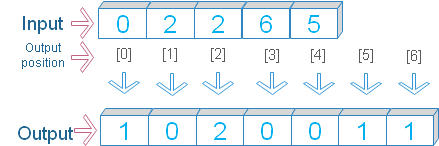 -->

### Считаем сумму/среднее

<div class="alert alert-info">

Для того, чтобы посчитать сумму значений в каждой группе мы можем воспользоваться `np.bincount(weights=your_weights)`

In [61]:
%%timeit
df_cars.groupby(['model', 'fuel_type'])['target_reg'].sum()

334 µs ± 1.37 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [62]:
%%timeit
np.bincount(df_cars['int_model'], weights=df_cars['target_reg'])

9.74 µs ± 25 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [63]:
gb_values = df_cars.groupby(['int_model'])['target_reg'].sum()
np_values = np.bincount(df_cars['int_model'], weights=df_cars['target_reg'])

(gb_values.round(10) == np_values.round(10)).all()

True

### Считаем минимум/максимум

<div class="alert alert-info">

Для того, чтобы посчитать такие функцие как максимум, минимум, произведение и тд нам потребуется `np.ufunc.reduceat()`

In [64]:
%%timeit
df_cars.groupby(['int_model'])['target_reg'].agg(['max'])

186 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [65]:
%%timeit
indices = df_cars['int_model']
max_values = np.maximum.reduceat(df_cars['target_reg'].values[np.argsort(indices)],
                                 np.concatenate(([0], np.cumsum(np.bincount(indices))))[:-1])
max_values

61.2 µs ± 2.33 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [66]:
indices = df_cars['int_model']
np_values = np.maximum.reduceat(df_cars['target_reg'].values[np.argsort(indices)],
                                 np.concatenate(([0], np.cumsum(np.bincount(indices))))[:-1])

gb_values = df_cars.groupby(['int_model'])['target_reg'].agg('max')
(gb_values.round(10) == np_values.round(10)).all()

True

In [38]:
# возвращает перестановку чисел от 0 до n - 1, в которой элементы отсортированы по возрастанию
np.argsort(indices).values, df_cars['int_model'].values[np.argsort(indices)]

(array([1168,  645,  189, ..., 1209, 1123, 1659]),
 array([ 0,  0,  0, ..., 25, 25, 25]))

In [41]:
# i-ый элемент хранит в себе сумму элементов первых i значений
np.bincount(indices), np.cumsum(np.bincount(indices))

(array([ 17,  20,  21,  16,  18, 161, 140, 143, 111, 147,  21,  23,  17,
         22, 146, 154, 152, 147, 118, 158, 130,  14, 152, 141, 135,  13]),
 array([  17,   37,   58,   74,   92,  253,  393,  536,  647,  794,  815,
         838,  855,  877, 1023, 1177, 1329, 1476, 1594, 1752, 1882, 1896,
        2048, 2189, 2324, 2337]))

In [42]:
# сдвигаем так, чтобы значения массива означали позиции начала групп
np.concatenate(([0], np.cumsum(np.bincount(indices))))[:-1]

array([   0,   17,   37,   58,   74,   92,  253,  393,  536,  647,  794,
        815,  838,  855,  877, 1023, 1177, 1329, 1476, 1594, 1752, 1882,
       1896, 2048, 2189, 2324])

## <center> ⚡️ `Numba Jit` </center>

<p id="c5"></p>   

<div class="alert alert-info">

Если нужно что-то кастномное, что нельзя переписать на `numpy`, но нужно чтобы работало быстро, `numba.jit` вам в помощь. Он конвертирует написанный вами на питоне код в С и засчет этого работает на порядок (а иногда и на несколько) быстрее, чем обычный питон. Однако, поддерживает он не весь питоновский функционал и внутри него нельзя использовать разные библиотечные функции, так что в основном используется для низкоуровневой оптимизации.

In [69]:
from numba import jit

@jit(nopython=True)
def f(n):
    s = 0.
    for i in range(n):
        s += i ** 0.5
    return s

In [68]:
%%timeit
f(10000)

531 µs ± 876 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [70]:
%%timeit
f(10000)

9.55 µs ± 10.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [73]:
@jit(nopython=True)
def monotonically_increasing(a):
    max_value = 0
    for i in range(len(a)):
        if a[i] > max_value:
            max_value = a[i]
        a[i] = max_value
    return a

In [72]:
%%timeit
monotonically_increasing(df_cars['target_reg'].values)

202 µs ± 390 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [74]:
%%timeit
monotonically_increasing(df_cars['target_reg'].values)

4.51 µs ± 22.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## <center> 🧵 Multiprocessing </center>
<p id="c6"></p>   

<div class="alert alert-info">
 
С помощью `multiprocessing` можно ускорить вообще практически все. Он позвлоляет использовать не одно ядро вашего компьютера, а сразу несколько и соответственно ускорить вычисления (уже не только io-bound, но еще и cpu-bound) в кол-во раз пропорциональное кол-ву доступных ядер.

In [86]:
import sys
sys.path.append('../src/')
import text_prepare
import importlib
importlib.reload(text_prepare)

<module 'text_prepare' from '/Users/sergak/Documents/Neyro_sets/Competitive_Data_Science/notebooks/../src/text_prepare.py'>

In [87]:
df = pd.read_csv('../data/blending/text_transformer_data.csv')
df.head()

,category,text
0,extreme,Ледник Пасторури это цирковой ледник расположе...
1,martial_arts,Главные участники предстоящего Betokenoid 274 ...
2,extreme,Ttokenoid Btokenoid – карта с которой можно не...
3,autosport,В Сильверстоуне произошли крупные обновления а...
4,extreme,На протяжении более чем 30 лет Вестсайд являет...


In [88]:
%%time

tmp = df['text'].apply(text_prepare.text_prepare)

CPU times: user 14.8 s, sys: 3.87 s, total: 18.7 s
Wall time: 19.1 s


In [91]:
from multiprocessing import Pool

In [92]:
def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = np.concatenate(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [93]:
%%time
tmp = parallelize_dataframe(df, text_prepare.many_row_prepare)

CPU times: user 11.3 ms, sys: 41 ms, total: 52.3 ms
Wall time: 7.03 s


## <center> 👻 Выводы </center>

<p id="c7"></p>   

<div class="alert alert-info">
    
Ускорение вычеслений и оптимизация памяти это важные задачи, с которыми периодически можно сталкнутся во время написания соревнований или просто при работе с большим кол-вом данных. В данном уроке мы рассмотрели основные способы решения этих задач и как их применять на практике.
    
Если тебе нужно ускорить твой код, то:
* Замени все, что можно на `numpy`
* Оставшееся перепиши на `numba.jit`
* Если предыдущх двух пунктов не хватило, то используй `multiprocessing`

Если нужно соптимизировать память, то:
* Хранения/считывание при помощи `pickle`
* Правильное выставление типов
* Если тебе не нужен весь датасет за раз, то можно считывать его по частям